# Inverse Physics Informed Neural Network for Navier-Stokes Equations

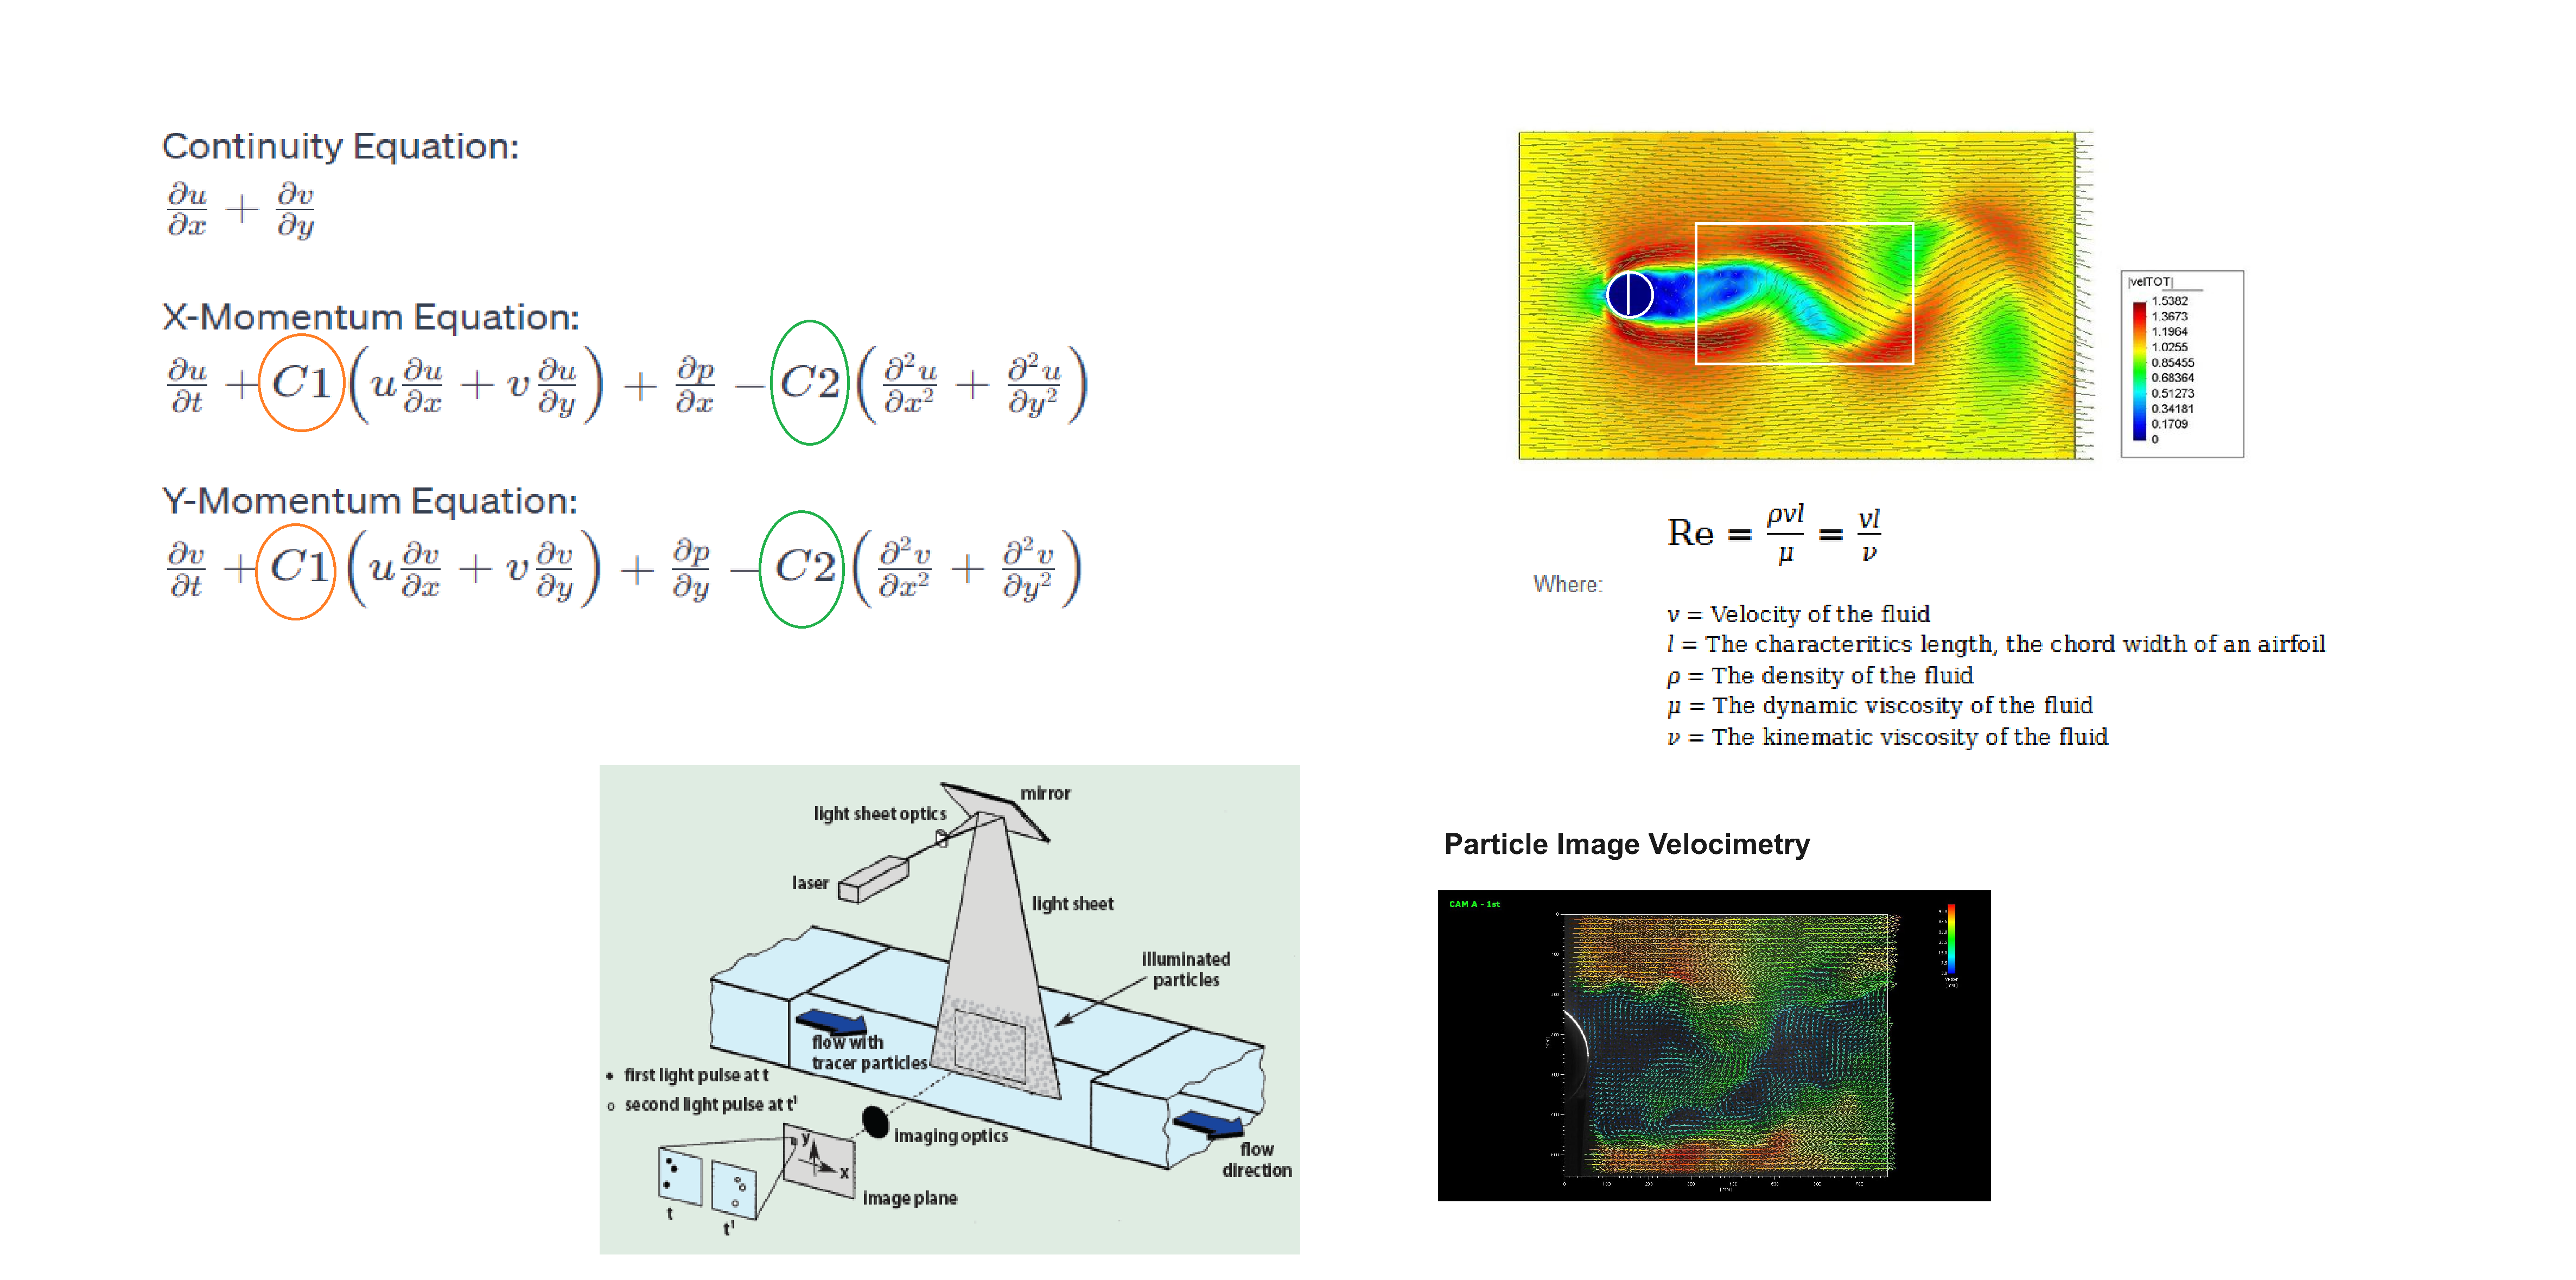

In this notebook we apply inverse PINNs to a 2D Karman flow field around a cylinder. We shall focus on the most critical area (see rectangle below) in the flow field wherein fluctuations in the flow field are commonly observed. Using a reduced form of Navier-Stokes Equations we first determine the kinematic viscosity of the fluid in using the velocities and pressures. We then reverse predict the pressure distribution using the velocity field and kinematic viscosity.

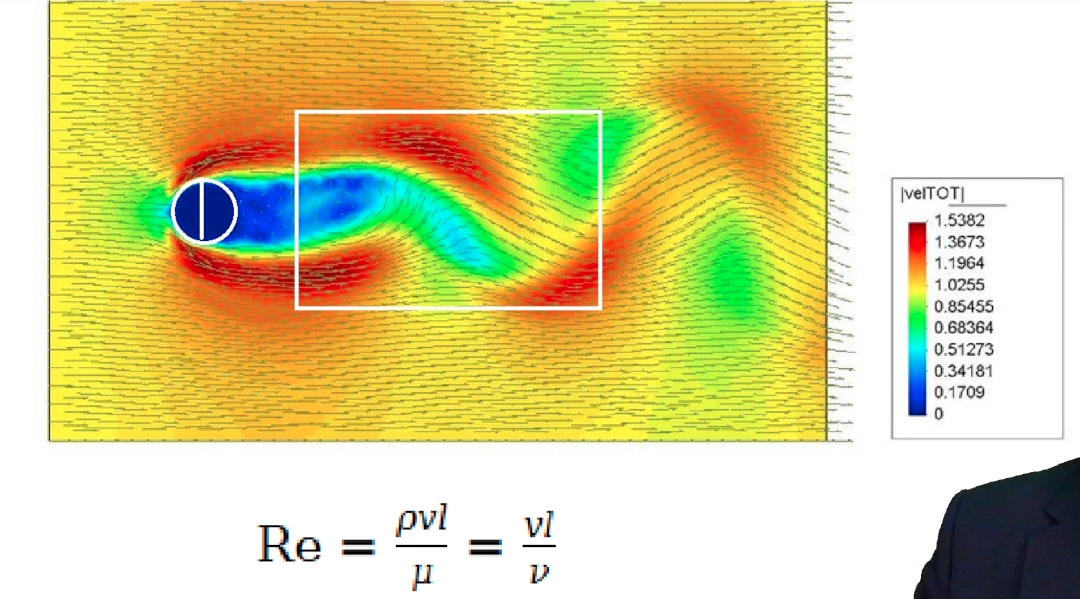

In [1]:
import deepxde as dde
from deepxde.backend import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
torch.get_default_device()

device(type='cpu')

In [3]:
# Check and set MPS device
if torch.backends.mps.is_available():
    #device = torch.device("mps")
    torch.set_default_device("mps")
    print("Using MPS device")
else:
    #device = torch.device("cpu")
    print("Using CPU")

Using MPS device


In [4]:
def fluidflow_data_from_mat(filepath, num):
    
    data = loadmat(filepath)

    U_star = data["U_star"] #Velocities have two components, u & v along x & y axes respectively
    p_star = data["p_star"] #Pressure is scalar
    t_star = data["t"]
    X_star = data["X_star"] #2D computational domain

    N = X_star.shape[0]
    T = t_star.shape[0]

    XX = np.tile(X_star[:, 0:1], (1,T))
    YY = np.tile(X_star[:, 1:2], (1,T))
    TT = np.tile(t_star, (1,N)).T
    UU = U_star[:, 0, :]
    VV = U_star[:, 1, :]
    PP = p_star
    

    x = XX.flatten()[:, None]
    y = YY.flatten()[:, None]
    t = TT.flatten()[:, None]
    u = UU.flatten()[:, None]
    v = VV.flatten()[:, None]
    p = PP.flatten()[:, None]


    data_domain = np.concatenate([x, y, t, u, v, p], 1)
    #[ob_x, ob_y, ob_t, ob_t, ob_u, ob_v, ob_p]

    #Area of interest: [x_low, x_high] = [1, 8]; [y_low, y_high] = [-2, 2], time interval [0, 7]
    data_slice_t        =       data_domain[:, :][data_domain[:, 2] <=7]         #slicing data from 0 <= t <= 7;
    data_slice_x_low    =       data_slice_t[:, :][data_slice_t[:, 0] >=1]   #slicing data x-coordinates >=1
    data_slice_x_high   =   data_slice_x_low[:, :][data_slice_x_low[:, 0] <=8] #slicing data x-coordinates <=8
    data_slice_y_low    =   data_slice_x_high[:, :][data_slice_x_high[:, 1] >=-2]
    data_slice_y_high   =   data_slice_y_low[:, :][data_slice_y_low[:, 1] <=2]

    data_comp = data_slice_y_high #Data in the computation space

    #result = print([U_star.shape, p_star.shape, t_star.shape, X_star.shape, TT.shape, t.shape, data_domain.shape, data_sliced.shape])
    #result = print([data_domain.shape, data_sliced.shape])

    idx = np.random.choice(data_comp.shape[0], num, replace=False) #An array of 'num' number of random indices chosen from the slice


    x_comp = data_comp[idx, 0:1]
    y_comp = data_comp[idx, 1:2]
    t_comp = data_comp[idx, 2:3]
    u_comp = data_comp[idx, 3:4]
    v_comp = data_comp[idx, 4:5]
    p_comp = data_comp[idx, 5:6]

    result = [x_comp, y_comp, t_comp, u_comp, v_comp, p_comp]

    return result

In [5]:
C1_meas = 1.0
C2_meas = 0.01
matfilepath = "Datasets/cylinder_nektar_wake.mat"

In [6]:
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0

comp_time       = dde.geometry.TimeDomain(0,7)
comp_space      = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
comp_spacetime  = dde.geometry.GeometryXTime(comp_space, comp_time)

In [7]:
[coord_x, coord_y, coord_t, meas_u, meas_v, meas_p] = fluidflow_data_from_mat(matfilepath, num=7000)

In [8]:
coord_xyt = np.hstack((coord_x, coord_y, coord_t))

Since we have data measured, merely defining the computation domain will suffice, as the intital and boundary conditions belong to the measured dataset.

In [9]:
train_u = dde.icbc.PointSetBC(coord_xyt, meas_u, component=0)
train_v = dde.icbc.PointSetBC(coord_xyt, meas_v, component=1)
train_p = dde.icbc.PointSetBC(coord_xyt, meas_p, component=2)

In [10]:
train_uvp = [train_u, train_v, train_p]

In [11]:
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)
print("C1 is computed in: ", C1.device)
print("C2 is computed in: ", C2.device)

C1 is computed in:  mps:0
C2 is computed in:  mps:0


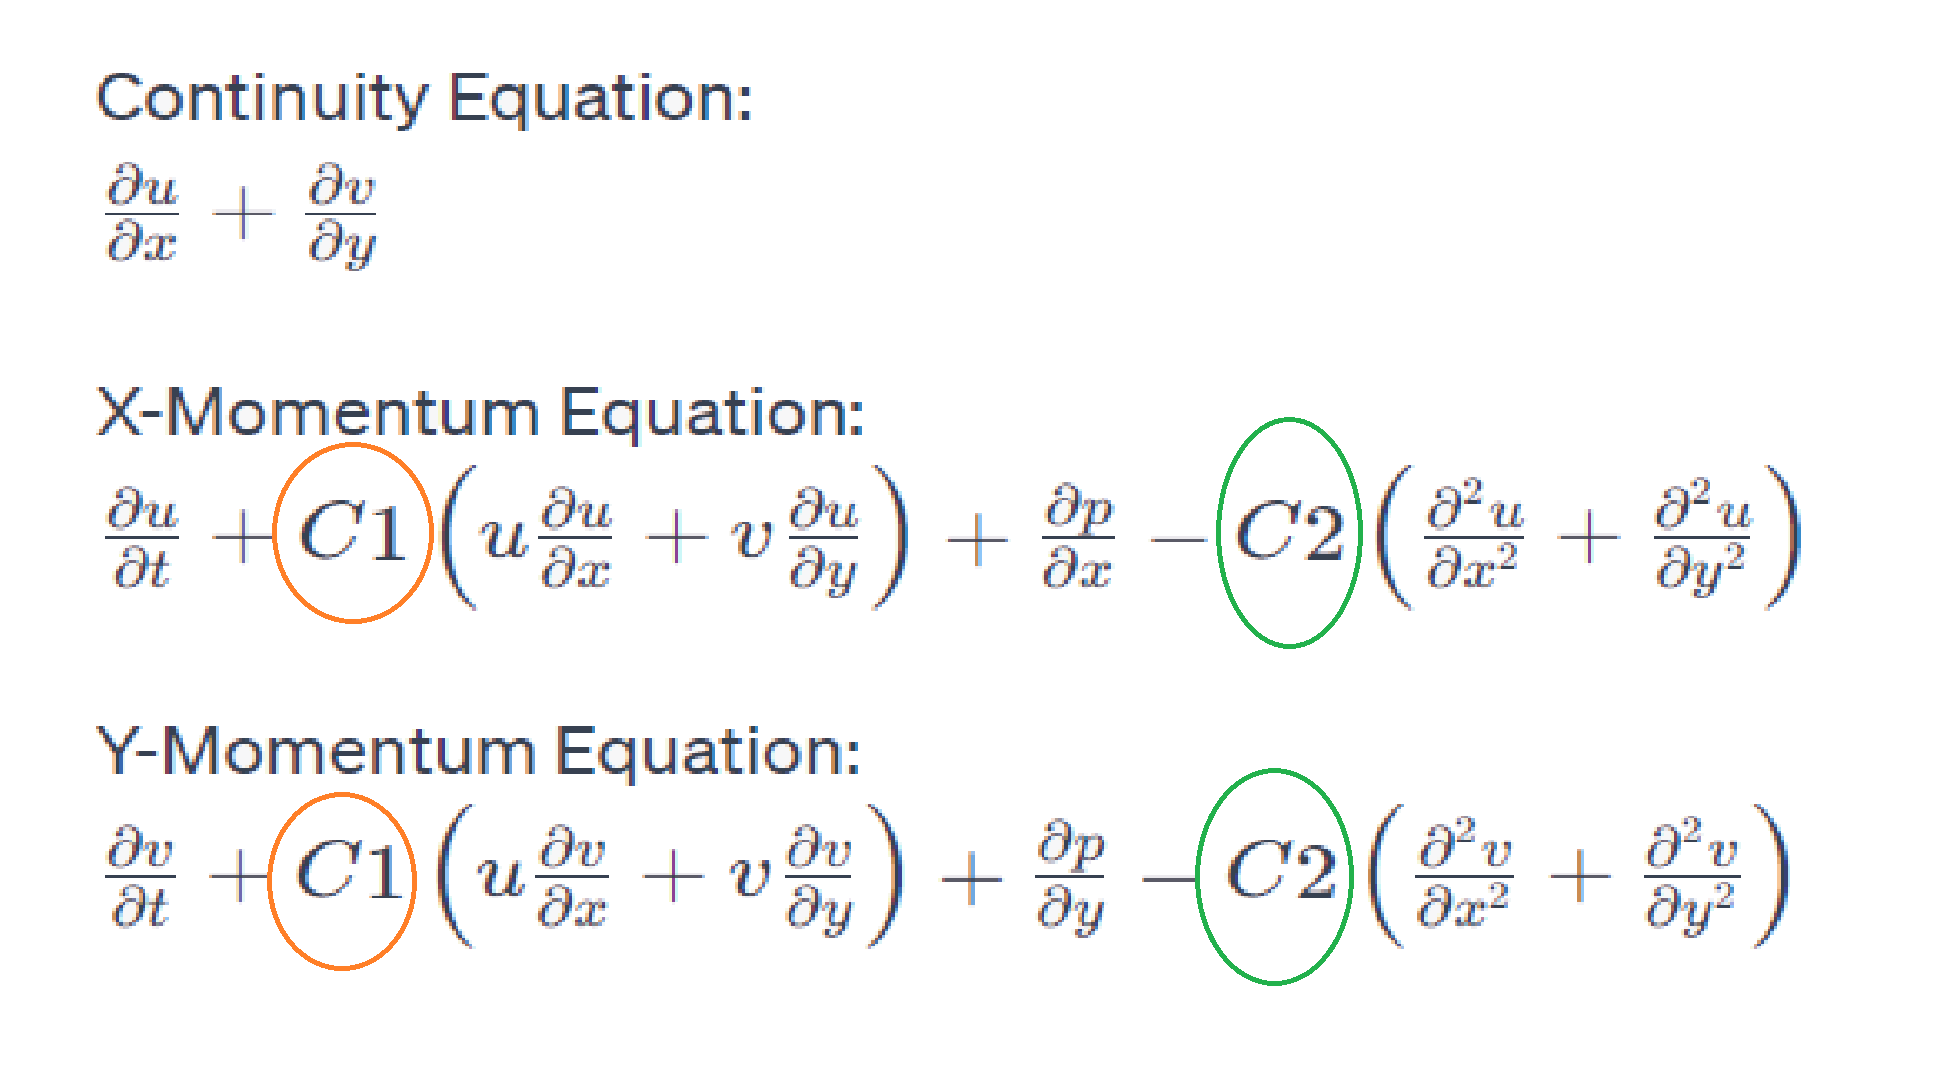

In [12]:
def NavierStokesEqn(x, y):
    
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]

    #First order differential terms:
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    du_dt = dde.grad.jacobian(y, x, i=0, j=2)

    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    dv_dt = dde.grad.jacobian(y, x, i=1, j=2)

    dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=2, j=1)

    #Second order differential terms
    ddu_dxx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    ddu_dyy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    ddv_dxx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    ddv_dyy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    #2D transient Navier Stokes Equation:
    continuity = du_dx + dv_dy                                                       #Continuity term
    x_momentum = du_dt + C1 * (u*du_dx + v*du_dy) + dp_dx - C2 * (ddu_dxx + ddu_dyy) #X-momentum term
    y_momentum = dv_dt + C1 * (u*dv_dx + v*dv_dy) + dp_dy - C2 * (ddv_dxx + ddv_dyy) #Y-momentum term

    result = [continuity, x_momentum, y_momentum]

    return result

In [13]:
#Training dataset used to calculate the loss:
train_data = dde.data.TimePDE(comp_spacetime,
                            NavierStokesEqn,
                            train_uvp,
                            num_domain=700,
                            num_boundary=200,
                            num_initial=100,
                            anchors=coord_xyt)

In [14]:
#Define the neural network architecture
layer_config = [3] + [50]*6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
NNet = dde.nn.FNN(layer_config, activation, initializer)

In [15]:
ModelNet = dde.Model(train_data, NNet)

In [16]:
train_hyper = [[1e-2, 5000], [1e-3, 4000], [1e-4, 3000]]
train_const = [C1, C2]

In [17]:
record_C1_C2 = "training_values_C1_C2.dat"
calls_C1_C2 = dde.callbacks.VariableValue(train_const, period=100, filename=record_C1_C2)

In [18]:
def train_karman_vortex_model(model, hyper_input, const_input):
    for i in range(len(hyper_input)):
        [rate_learn, iter_num] = hyper_input[i]
        model.compile("adam", lr=rate_learn, external_trainable_variables=const_input)
        loss_history, train_state = model.train(iterations=iter_num, callbacks=[calls_C1_C2], display_every=1000, disregard_previous_best=True)
        dde.saveplot(loss_history, train_state, issave=True)

    f = model.predict(coord_xyt, operator=NavierStokesEqn)
    print("Training completed with mean residual of: ", np.mean(np.absolute(f)))
    model.save("PINNs_Inv_trained_model")
    
    return model, loss_history, train_state


Compiling model...
'compile' took 0.584793 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [3.74e-03, 2.16e-03, 6.30e-02, 1.21e+00, 2.82e-01, 1.45e-01]    [3.74e-03, 2.16e-03, 6.30e-02, 1.21e+00, 2.82e-01, 1.45e-01]    []  
1000      [2.48e-04, 3.60e-04, 3.03e-04, 6.83e-04, 7.95e-04, 1.37e-04]    [2.48e-04, 3.60e-04, 3.03e-04, 6.83e-04, 7.95e-04, 1.37e-04]    []  
2000      [3.75e-04, 4.45e-04, 7.30e-04, 2.91e-03, 1.77e-03, 2.52e-04]    [3.75e-04, 4.45e-04, 7.30e-04, 2.91e-03, 1.77e-03, 2.52e-04]    []  
3000      [2.60e-04, 1.48e-04, 1.84e-04, 3.82e-04, 3.27e-04, 8.46e-05]    [2.60e-04, 1.48e-04, 1.84e-04, 3.82e-04, 3.27e-04, 8.46e-05]    []  
4000      [8.00e-05, 1.13e-04, 8.54e-05, 1.08e-04, 2.48e-04, 2.31e-05]    [8.00e-05, 1.13e-04, 8.54e-05, 1.08e-04, 2.48e-04, 2.31e-05]    []  
5000      [3.04e-04, 1.52e-04, 2.39e-04, 8.10e-04, 1.11e-03, 2.37e-04]

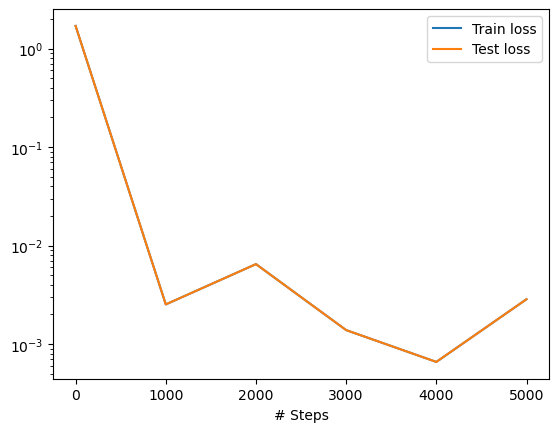

Compiling model...
'compile' took 0.001028 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
5000      [3.04e-04, 1.52e-04, 2.39e-04, 8.10e-04, 1.11e-03, 2.37e-04]    [3.04e-04, 1.52e-04, 2.39e-04, 8.10e-04, 1.11e-03, 2.37e-04]    []  
6000      [3.65e-05, 3.08e-05, 3.21e-05, 3.99e-05, 4.40e-05, 6.08e-06]    [3.65e-05, 3.08e-05, 3.21e-05, 3.99e-05, 4.40e-05, 6.08e-06]    []  
7000      [1.65e-05, 1.99e-05, 2.15e-05, 1.73e-05, 3.09e-05, 4.08e-06]    [1.65e-05, 1.99e-05, 2.15e-05, 1.73e-05, 3.09e-05, 4.08e-06]    []  
8000      [1.38e-05, 1.64e-05, 1.70e-05, 1.51e-05, 2.79e-05, 3.60e-06]    [1.38e-05, 1.64e-05, 1.70e-05, 1.51e-05, 2.79e-05, 3.60e-06]    []  
9000      [1.23e-05, 1.54e-05, 1.48e-05, 1.53e-05, 3.01e-05, 3.53e-06]    [1.23e-05, 1.54e-05, 1.48e-05, 1.53e-05, 3.01e-05, 3.53e-06]    []  

Best model at step 9000:
  train loss: 9.14e-05
  test loss: 9.14e-05

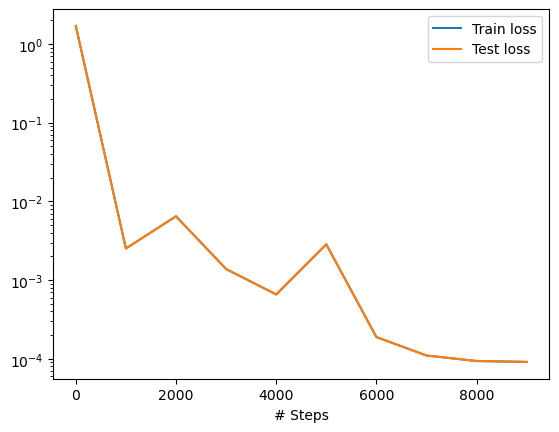

Compiling model...
'compile' took 0.000640 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
9000      [1.23e-05, 1.54e-05, 1.48e-05, 1.53e-05, 3.01e-05, 3.53e-06]    [1.23e-05, 1.54e-05, 1.48e-05, 1.53e-05, 3.01e-05, 3.53e-06]    []  
10000     [1.01e-05, 1.23e-05, 1.25e-05, 1.13e-05, 2.39e-05, 2.99e-06]    [1.01e-05, 1.23e-05, 1.25e-05, 1.13e-05, 2.39e-05, 2.99e-06]    []  
11000     [8.90e-06, 1.09e-05, 1.10e-05, 1.04e-05, 2.28e-05, 2.80e-06]    [8.90e-06, 1.09e-05, 1.10e-05, 1.04e-05, 2.28e-05, 2.80e-06]    []  
12000     [7.97e-06, 9.86e-06, 9.75e-06, 9.62e-06, 2.20e-05, 2.64e-06]    [7.97e-06, 9.86e-06, 9.75e-06, 9.62e-06, 2.20e-05, 2.64e-06]    []  

Best model at step 12000:
  train loss: 6.19e-05
  test loss: 6.19e-05
  test metric: []

'train' took 1345.779512 s

Saving loss history to /Users/mdsouza/Documents/PythonProjects/PINNs/loss.dat ...
Saving train

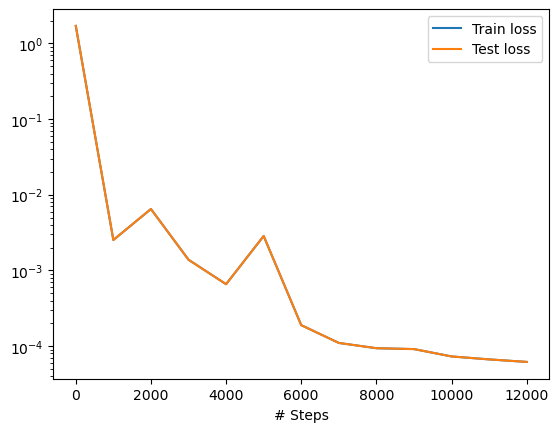

Training completed with mean residual of:  0.0021387278


In [19]:
karman_model, history_loss, state_train = train_karman_vortex_model(ModelNet, train_hyper, train_const)

# Restore the trained model
Ensure data, boundary conditions and net are made available again,
i.e data, bc & net

In [24]:
# Create a new model instance
model = dde.Model(train_data, NNet)

In [ ]:
karman_model_trained = model.restore("InvPINNs_trained_model-10000.pt", verbose=1)

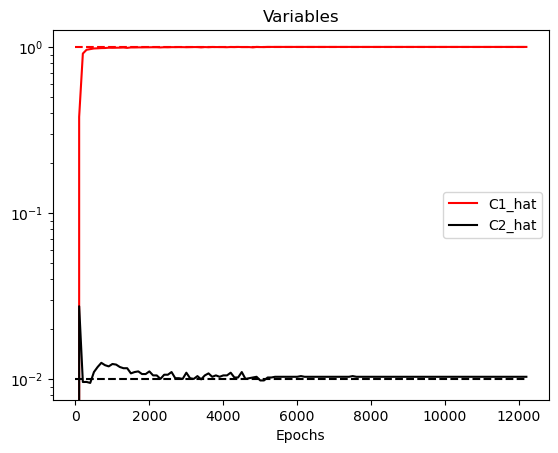

In [20]:
# Plot Variables:
# reopen saved data using callbacks in results_file_C1_C2

training_values_C1_C2 = "training_values_C1_C2.dat"
lines = open(training_values_C1_C2, "r").readlines()
# read output data in fnamevar
C_hat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = C_hat.shape
plt.semilogy(range(0, l * 100, 100), C_hat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), C_hat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(C_hat[:, 0].shape) * C1_meas, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(C_hat[:, 1].shape) * C2_meas, "k--")
plt.legend(["C1_hat", "C2_hat"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

In [21]:
# Plot the velocity distribution of the flow field:
[eval_x, eval_y, eval_t, eval_u, eval_v, eval_p] = fluidflow_data_from_mat(matfilepath, num=140000)
for t in range(0, 8):
    #[eval_x, eval_y, eval_t, eval_u, eval_v, eval_p] = comp_data_from_mat(matfilepath, num=140000)
    xyt_eval = np.hstack((eval_x, eval_y, t * np.ones((len(eval_x), 1))))
    uvp_pred = karman_model.predict(xyt_eval)
    x_pred, y_pred, t_pred = xyt_eval[:, 0], xyt_eval[:, 1], xyt_eval[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_data = eval_x[eval_t == t]
    y_data = eval_y[eval_t == t]
    u_data = eval_u[eval_t == t]
    v_data = eval_v[eval_t == t]
    p_data = eval_p[eval_t == t]

In [22]:
np.linspace(min(u_pred), max(u_pred), 5)

array([-0.23080808,  0.15582846,  0.542465  ,  0.92910154,  1.31573808])

In [26]:
[min(u_pred), max(u_pred)]

[-0.23080808, 1.3157381]

In [24]:
def calculate_colorbar_range(input_array):
    """
    Calculate a colorbar range with levels that are multiples of specific values
    (e.g., 0.5, 1.0, 2.0, 5.0, 10.0, etc.).
    
    Parameters:
        data_min (float): The minimum value in the data.
        data_max (float): The maximum value in the data.

    Returns:
        levels (numpy.ndarray): An array of evenly spaced levels for the colorbar.
    """
    # Define possible step intervals
    intervals = [0.5, 1.0, 2.0, 5.0, 10.0, 25.0, 50.0, 100.0, 150.0, 200.0, 250.0, 500.0, 1000.0]
    
    [data_min, data_max] = [min(input_array), max(input_array)]
    # Find the difference between max and min values
    data_range = data_max - data_min
    
    # Select the smallest interval that can divide the range into reasonable steps
    step = next(interval for interval in intervals if data_range / interval <= 10)
    
    # Adjust the min and max values to the nearest multiple of the chosen step
    adjusted_min = np.floor(data_min / step) * step
    adjusted_max = np.ceil(data_max / step) * step
    
    # Generate the levels
    levels = np.arange(adjusted_min, adjusted_max + step, step)
    
    return levels

In [25]:
calculate_colorbar_range(u_pred)

array([-0.5,  0. ,  0.5,  1. ,  1.5])

In [31]:
calculate_colorbar_range(u_data)

array([-0.5,  0. ,  0.5,  1. ,  1.5])

In [35]:
calculate_colorbar_range(np.union1d(u_pred, u_data))

array([-0.5,  0. ,  0.5,  1. ,  1.5])

In [36]:
min(calculate_colorbar_range(np.union1d(u_pred, u_data)))

-0.5

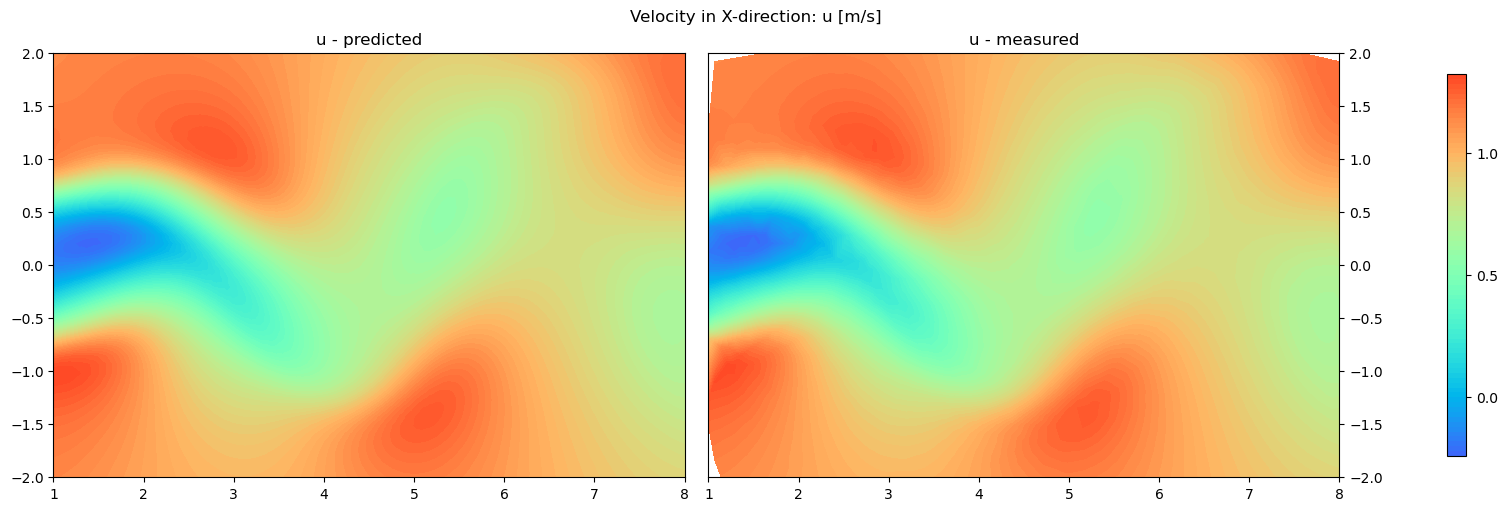

In [105]:
fig0, axs0 = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')#, constrained_layout=True)
levels_u = calculate_colorbar_range(np.union1d(u_pred, u_data))
fig0.suptitle("Velocity in X-direction: u [m/s]")
cntr00 = axs0[0].tricontourf(x_pred, y_pred, u_pred, vmin=min(levels_u), vmax=max(levels_u), levels=100, cmap="rainbow")
axs0[0].set_title('u - predicted')
cntr01 = axs0[1].tricontourf(x_data, y_data, u_data, vmin=min(levels_u), vmax=max(levels_u), levels=100, cmap="rainbow")
axs0[1].yaxis.tick_right()
axs0[1].set_title('u - measured')
fig0.colorbar(cntr01, ax=axs0, ticks=levels_u, shrink=0.9, extend='both')
plt.show()

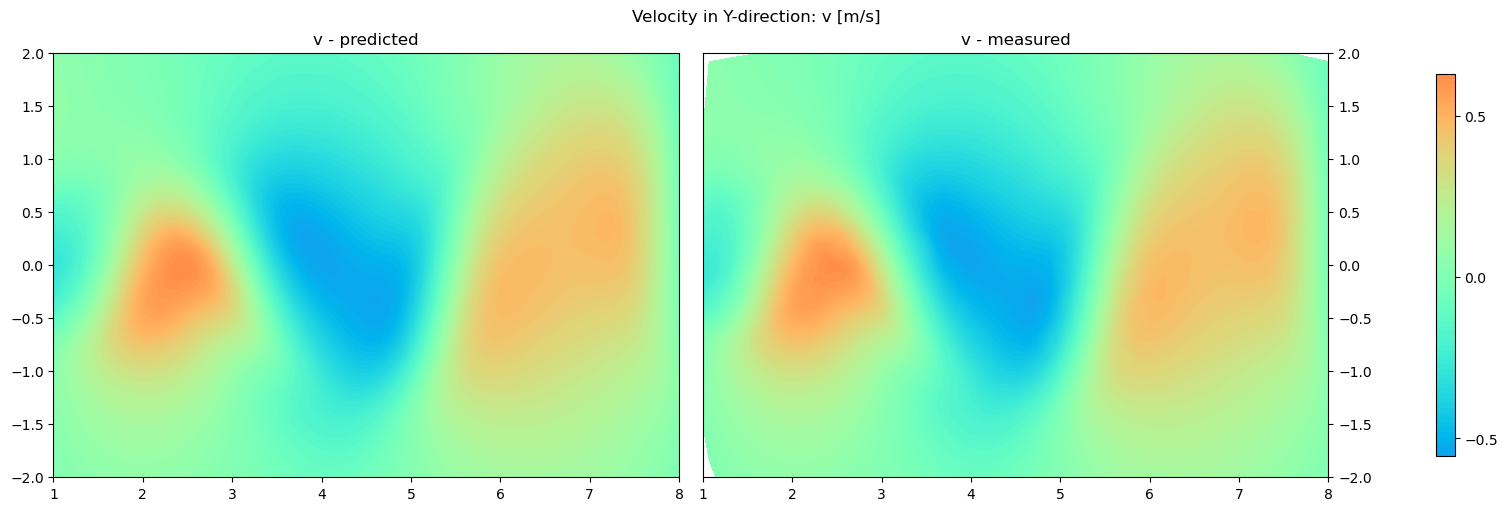

In [107]:
fig1, axs1 = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')#, constrained_layout=True)
levels_v = calculate_colorbar_range(np.union1d(v_pred, v_data))
fig1.suptitle("Velocity in Y-direction: v [m/s]")

cntr10 = axs1[0].tricontourf(x_pred, y_pred, v_pred, vmin=min(levels_v), vmax=max(levels_v), levels=100, cmap="rainbow")
axs1[0].set_title('v - predicted')

cntr11 = axs1[1].tricontourf(x_data, y_data, v_data, vmin=min(levels_v), vmax=max(levels_v), levels=100, cmap="rainbow")
axs1[1].yaxis.tick_right()
axs1[1].set_title('v - measured')

fig1.colorbar(cntr11, ax=axs1, ticks=levels_v, shrink=0.9, extend='both')
plt.show()

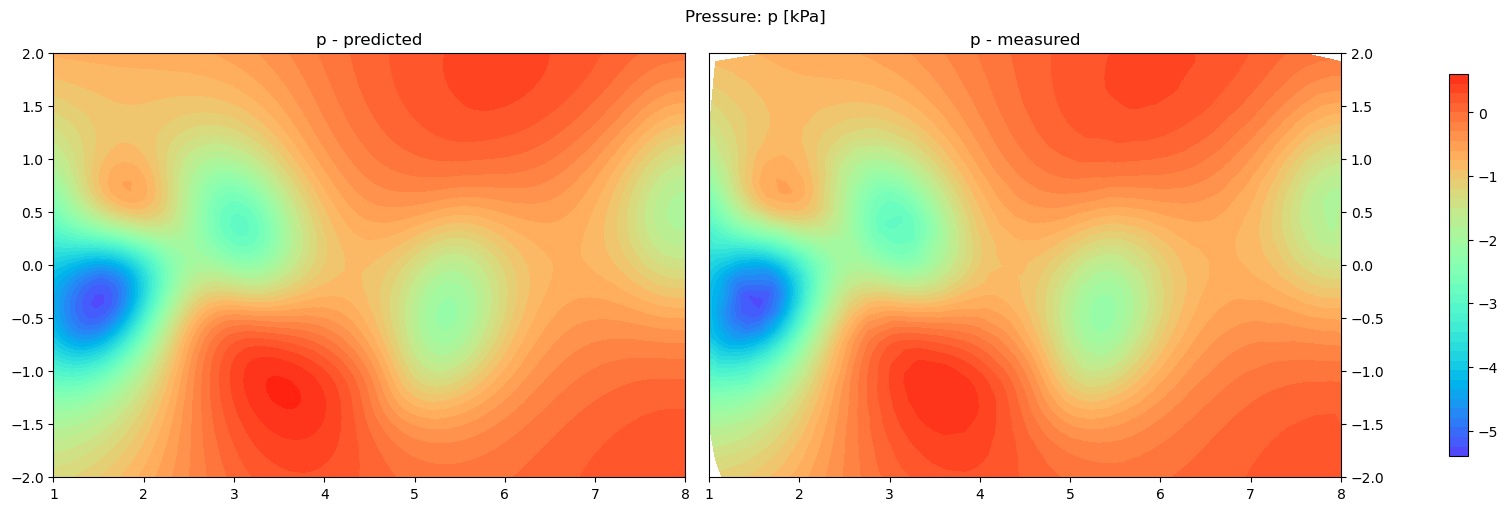

In [141]:
fig2, axs2 = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')
levels_p = calculate_colorbar_range(np.union1d(p_pred, p_data)*10)
fig2.suptitle("Pressure: p [kPa]")

cntr20 = axs2[0].tricontourf(x_pred, y_pred, p_pred*10, vmin=min(levels_p), vmax=max(levels_p), levels=50, cmap="rainbow")
axs2[0].set_title('p - predicted')

cntr21 = axs2[1].tricontourf(x_data, y_data, p_data*10, vmin=min(levels_p), vmax=max(levels_p), levels=50, cmap="rainbow")
axs2[1].yaxis.tick_right()
axs2[1].set_title('p - measured')

fig2.colorbar(cntr21, ax=axs2, ticks=levels_p, shrink=0.9, extend='both')
plt.show()

In [112]:
levels_p

array([-1. , -0.5,  0. ,  0.5])

In [131]:
calculate_colorbar_range(p_pred*10)

array([-6., -5., -4., -3., -2., -1.,  0.,  1.])

In [129]:
max(calculate_colorbar_range(np.union1d(p_pred, p_data)*10))

1.0